In [1]:
from mordenNN import *
import pandas as pd
from sklearn.model_selection import train_test_split
from EDA import *
from sklearn.preprocessing import LabelEncoder
from torch.optim import AdamW
import torch.nn.functional as F
import pandas as pd

[nltk_data] Downloading package wordnet to /Users/yaoyao/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/yaoyao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
def read_data(fpath):
    
    df = pd.read_csv(fpath)
    le = LabelEncoder()
    df['category'] = le.fit_transform(df['category'])
    
    all_words = [w for text in df['text'] for w in text.split()]
    all_words_freq = pd.Series(all_words).value_counts()
        
    train, test = train_test_split(df, test_size=0.2, random_state=42)
    val, test = train_test_split(test, test_size=0.5, random_state=42)
    print(f'Train set length: {len(train)} ; categories: {train["category"].nunique()}')
    print(f'Val set length: {len(val)} ; categories: {val["category"].nunique()}')
    print(f'Test set length: {len(test)} ; categories: {test["category"].nunique()}')
    word2index, index2word = prepare_text_dict(all_words_freq)
    train_data = Data(train, word2index)
    val_data = Data(val, word2index)
    test_data = Data(test, word2index)

    # bert_train_data = Bert_data(train)
    # bert_val_data = Bert_data(val)
    # bert_test_data = Bert_data(test)
    
    # label2encoding = dict(zip(le.classes_, le.transform(le.classes_)))
    # encoding2label = dict(zip(le.transform(le.classes_), le.classes_))
    
    train_loader = DataLoader(train_data, batch_size=32, collate_fn=collate_fn_padded)
    val_loader = DataLoader(val_data, batch_size=32, collate_fn=collate_fn_padded)
    test_loader = DataLoader(test_data, batch_size=32, collate_fn=collate_fn_padded)

    # bert_train_loader = DataLoader(bert_train_data, batch_size=12)
    # bert_val_loader = DataLoader(bert_val_data, batch_size=12)
    # bert_test_loader = DataLoader(bert_test_data, batch_size=12)
    vector_size = 50
    word2vec_embeddings = get_mapping_dict(df, word2index, vector_size= vector_size, use_sentiment=True)
    embedding_matrix = create_embedding_matrix( word2index, word2vec_embeddings, vector_size)
    
    return train_loader, val_loader, test_loader, word2index

In [3]:

fpaths = [
          #'./data/df_all_category_nobalance.csv', # kernel died
          #'./data/df_10_category_nobalance.csv', # kernel died
          './data/df_10_category_balance.csv',
          './data/df_10_category_balance_60k.csv',
          './data/df_10_category_balance_30k.csv',
          './data/df_10_category_balance_10k_pca.csv',
          './data/df_10_category_balance_3k_pca.csv'
          ]
fpaths = fpaths[::-1]
fnames = ['3k', '10k', '30k', '60k', '100k']
#names = ['3k']
df_lists = [pd.read_csv(fpath) for fpath in fpaths]

In [4]:

output_size = 10
# common variables for both models
best_embedding_dim = 100
best_hidden_size = 64
# LSTM Model variables
best_n_layers = 2

# variables of CNN
best_n_filters = 32
filter_sizes = [2, 3, 5, 7]
loss_list = {}
f1_list = {}
accuracy_list = {}

for i, df in enumerate(df_lists):
    train_loader, val_loader, test_loader, word2index = read_data(fpaths[i])
    vocab_size = len(word2index)
    print('*************************')
    print(f'start training on dataset: {fpaths[i]}')
    print('Size Of Vocab: ', vocab_size)
    # CNN Model variables
    print(f'CNN Model Starts:')
    model_cnn = CNN_Model(vocab_size, best_embedding_dim, best_hidden_size, best_n_filters, filter_sizes, output_size)
    model_lstm = LSTM_Model(vocab_size, best_embedding_dim, best_hidden_size, best_n_layers, output_size)
    models = [model_cnn, model_lstm]
    loss_function = nn.CrossEntropyLoss().to(device)
    def count_parameters(model):
        # to know how many parametres a 'trained' model has  
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    loss_list[fnames[i]] = {}
    f1_list[fnames[i]] = {}
    accuracy_list[fnames[i]] = {}
    for model in models:
        print('----------------------')
        print('model Name: ', type(model).__name__) # print Model Name
        print(f'{type(model).__name__} has {count_parameters(model):,} trainable parameters') # print Model Total Parameters 
        #model = model.to(device) # convert model to GPU memory for fast training
        optimizer = AdamW(model.parameters(), lr= 0.01, weight_decay=0.01) # assign AdamW as optimizer
        training_model(model, optimizer, loss_function, train_loader, val_loader, epochs=100, using_features=False)
        loss, f1, accuracy, name = pred(model, test_loader, loss_function, using_features=False)
        loss_list[fnames[i]][name] = loss
        f1_list[fnames[i]][name] = f1
        accuracy_list[fnames[i]][name] = accuracy
    

Train set length: 2400 ; categories: 10
Val set length: 300 ; categories: 10
Test set length: 300 ; categories: 10

word2vec embeddings...
word2vec embeddings found for our vocabs: 12792 | missing: 0 ; 0.0%
*************************
start training on dataset: ./data/df_10_category_balance_3k_pca.csv
Size Of Vocab:  12792
CNN Model Starts:
----------------------
model Name:  CNN_Model
CNN_Model has 1,335,018 trainable parameters

Training Started...



/Users/yaoyao/Desktop/CourseExercise/ENLP/mordenNN.py:271: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:264.)
  features = torch.tensor(features, device=device, dtype=torch.float)


BEST Epoch(1 | Train(loss: 2.7226 | acc: 15.8 | f1-score: 10.3) & Eval(loss: 2.1333 | acc: 23.0 | f1-score: 14.1)

BEST Epoch(2 | Train(loss: 2.288 | acc: 29.0 | f1-score: 20.4) & Eval(loss: 1.9319 | acc: 35.3 | f1-score: 29.9)

BEST Epoch(3 | Train(loss: 1.8022 | acc: 47.4 | f1-score: 38.6) & Eval(loss: 1.9136 | acc: 39.5 | f1-score: 35.9)

BEST Epoch(4 | Train(loss: 1.323 | acc: 62.5 | f1-score: 52.8) & Eval(loss: 2.2843 | acc: 42.2 | f1-score: 36.9)

Epoch(5 | Train(loss: 0.9735 | acc: 75.8 | f1-score: 70.0) & Eval(loss: 3.322 | acc: 42.0 | f1-score: 38.0)

BEST Epoch(6 | Train(loss: 0.724 | acc: 83.3 | f1-score: 77.6) & Eval(loss: 3.5208 | acc: 46.4 | f1-score: 41.5)

Epoch(7 | Train(loss: 0.6899 | acc: 85.5 | f1-score: 81.0) & Eval(loss: 4.7542 | acc: 45.8 | f1-score: 37.7)

BEST Epoch(8 | Train(loss: 0.5951 | acc: 88.6 | f1-score: 84.2) & Eval(loss: 5.0748 | acc: 48.3 | f1-score: 40.2)

BEST Epoch(9 | Train(loss: 0.5929 | acc: 90.1 | f1-score: 85.5) & Eval(loss: 5.4594 | acc: 52.

In [5]:
loss_list

{'3k': {'CNN_Model': 15.4216, 'LSTM_Model': 3.6302},
 '10k': {'CNN_Model': 17.7951, 'LSTM_Model': 3.917},
 '30k': {'CNN_Model': 3.7134, 'LSTM_Model': 1.8351},
 '60k': {'CNN_Model': 2.1216, 'LSTM_Model': 1.5368},
 '100k': {'CNN_Model': 1.576, 'LSTM_Model': 1.1963}}

In [6]:
accuracy_list

{'3k': {'CNN_Model': 51.9, 'LSTM_Model': 35.2},
 '10k': {'CNN_Model': 57.8, 'LSTM_Model': 56.4},
 '30k': {'CNN_Model': 60.8, 'LSTM_Model': 65.3},
 '60k': {'CNN_Model': 61.1, 'LSTM_Model': 68.7},
 '100k': {'CNN_Model': 62.9, 'LSTM_Model': 70.7}}

In [7]:
f1_list

{'3k': {'CNN_Model': 42.3, 'LSTM_Model': 30.7},
 '10k': {'CNN_Model': 50.0, 'LSTM_Model': 48.4},
 '30k': {'CNN_Model': 54.7, 'LSTM_Model': 58.1},
 '60k': {'CNN_Model': 54.3, 'LSTM_Model': 61.2},
 '100k': {'CNN_Model': 57.0, 'LSTM_Model': 63.5}}

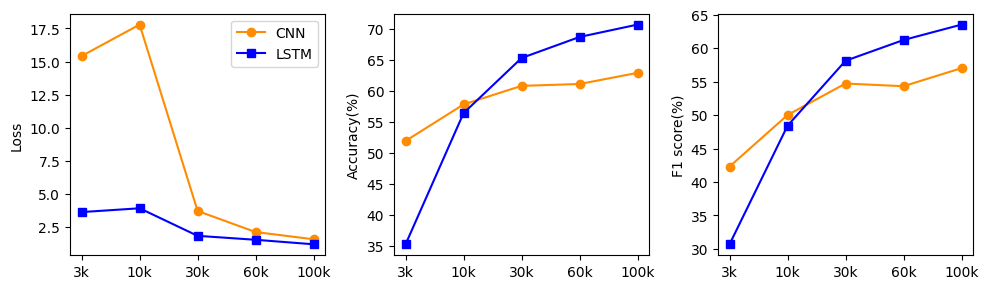

In [8]:
x = loss_list.keys()
cnn_loss = [loss_list[i]['CNN_Model'] for i in x]
lstm_loss = [loss_list[i]['LSTM_Model'] for i in x]
cnn_acc = [accuracy_list[i]['CNN_Model'] for i in x]
lstm_acc = [accuracy_list[i]['LSTM_Model'] for i in x]
cnn_f1 = [f1_list[i]['CNN_Model'] for i in x]
lstm_f1 = [f1_list[i]['LSTM_Model'] for i in x]

plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
plt.plot(x, cnn_loss, label='CNN', color='darkorange', marker='o')
plt.plot(x, lstm_loss, label='LSTM', color='blue', marker='s')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(x, cnn_acc, label='CNN', color='darkorange', marker='o')
plt.plot(x, lstm_acc, label='LSTM', color='blue', marker='s')
plt.ylabel('Accuracy(%)')
# plt.legend()
plt.subplot(1, 3, 3)
plt.plot(x, cnn_f1, label='CNN', color='darkorange', marker='o')
plt.plot(x, lstm_f1, label='LSTM', color='blue', marker='s')
plt.ylabel('F1 score(%)')
# plt.legend()
plt.tight_layout()
plt.show()


In [9]:
# loss_list = {}
# f1_list = {}
# accuracy_list = {}
# for fname, models in model_list.items():
#     print(f'evaluate on dataset {fname}')
#     loss_list[fname] = {}
#     f1_list[fname] = {}
#     accuracy_list[fname] = {}
#     for model in models:
#         loss, f1, accuracy, name = pred(model, test_loader, loss_function, using_features=False)
#         print(f'{name} results: loss: {loss:.4f} ; accuracy: {accuracy:.4f} ; f1: {f1:.4f}')
#         loss_list[fname][name] = loss
#         f1_list[fname][name] = f1
#         accuracy_list[fname][name] = accuracy